<a href="https://www.kaggle.com/code/shusrith/worker?scriptVersionId=173579644" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Fall Detection using smartphone sensors

The MobiFall dataset collect data from the accelerometer and the gyroscope of a smartphone along the X, Y and Z axes. 400 such samples are collected for each action within a 2 second sliding window. The dataset consists of 8000 rows, each with 1200 features and one target column. We load the dataset into memory for processing.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/mobifaller/train.csv")
df1 = pd.read_csv("/kaggle/input/mobifaller/test.csv")
x = df.drop("label", axis=1)
y = [1 if i == 0 else 0 for i in df["label"]]
x

,1,2,3,4,5,6,7,8,9,10,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,167.0,199.0,217.0,226.0,216.0,229.0,232.0,235.0,236.0,236.0,...,133.0,123.0,117.0,115.0,117.0,118.0,118.0,118.0,120.0,125.0
1,171.0,172.0,185.0,204.0,218.0,217.0,208.0,196.0,187.0,180.0,...,154.0,155.0,150.0,143.0,137.0,133.0,130.0,128.0,128.0,129.0
2,120.0,130.0,137.0,142.0,143.0,152.0,153.0,143.0,146.0,165.0,...,109.0,112.0,120.0,126.0,131.0,132.0,152.0,193.0,206.0,181.0
3,122.0,122.0,122.0,123.0,124.0,125.0,125.0,125.0,124.0,124.0,...,113.0,111.0,110.0,110.0,110.0,112.0,114.0,117.0,119.0,118.0
4,162.0,20.0,189.0,161.0,20.0,190.0,160.0,19.0,189.0,159.0,...,205.0,162.0,166.0,204.0,161.0,166.0,204.0,161.0,166.0,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,187.0,184.0,182.0,180.0,176.0,170.0,160.0,152.0,143.0,136.0,...,156.0,159.0,158.0,158.0,159.0,162.0,165.0,167.0,161.0,144.0
7996,173.0,172.0,171.0,170.0,170.0,171.0,171.0,171.0,171.0,170.0,...,95.0,89.0,85.0,83.0,86.0,88.0,92.0,101.0,114.0,127.0
7997,165.0,197.0,211.0,207.0,202.0,206.0,219.0,228.0,232.0,234.0,...,55.0,42.0,38.0,42.0,50.0,60.0,72.0,87.0,105.0,118.0
7998,128.0,128.0,128.0,128.0,128.0,128.0,128.0,129.0,129.0,129.0,...,114.0,116.0,121.0,122.0,117.0,103.0,96.0,89.0,85.0,87.0


The imbalance in the data is clearly visible and hence measures need to be taken to address the imbalance before training.

In [2]:
pd.DataFrame(y).value_counts()

0
0    7021
1     979
Name: count, dtype: int64

### Validation data 

Since we are generating samples using SMOTE and TOMEK links, we separate out half of the actual data initially for the purpose of validation during training. This is done to keep the validation data unseen by the model to find the actual extent of its generalization.

In [3]:
from sklearn.model_selection import train_test_split

a, val_input, b, val_output = train_test_split(x, y, test_size=0.5, random_state=42)

# Handling Imbalance

We use the combination of SMOTE and TOMEK links to handle the imbalance in the data. SMOTE gives us synthetic data points that are located at a random distance between any two clusters of the minority class. By using SMOTE we can oversample the data and increase the number of instances of the minority class and train the model better. 

TOMEK links are an undersampling method that finds the data points of opposing classes that are close to each other and removes the data point of the majority class. This coupled along with SMOTE can make the data lot more balanced for efficient training.

## Custom SMOTE and TOMEK link methods

To test our understanding of the concepts and to have more control over the data, we have implemented custom methods to perform SMOTE and TOMEK link techniques. We cluster the data points using nearest neighbours and return the clusters obtained. Using these clusters, both methods are implemented

In [4]:
from sklearn.neighbors import NearestNeighbors

def nearest_neighbour(neighbours,x):
    n=NearestNeighbors(n_neighbors=neighbours,algorithm="ball_tree")
    n.fit(x)
    dist,indices=n.kneighbors(x)
    return indices
    

## SMOTE

SMOTE generates synthetic samples based on the clusters created. In our custom implementation, we call the function with the number of neighbours and the number of synthetic points to be generated per data point, `n`,  as the parameters. For each point, the loop iterates n times and chooses a random neighbour from one of the clusters. Then it selects a point at a random distance on the line between the neighbour and the point, and this randomly selected point is a synthetic point that belongs to the minority class and is used for oversampling to solve imbalance.

In [5]:
import random
def smote(x, neighbours, n):
    k = nearest_neighbour(neighbours, x)
    l = []
    for i in range(len(x)):
        for j in range(n):
            r = random.choice(k[i])
            dist = x[r] - x[i]
            rd = random.random()
            l.append(x[i] + (rd * dist))
    return np.array(l)

The elements of the minority classes are selected for SMOTE to be applied on them.

In [6]:
indices=[]
for i, j in enumerate(y):
    if j == 1:
        indices.append(x.iloc[i, :])
indices=np.array(indices)
indices.shape

(979, 1200)

We call the SMOTE function with 5 neighbours and generating 3 synthetic points per data point. The returned array has only samples of the minority class and the imbalance in the data is removed.

In [7]:
l = smote(indices, 5, 3)
l.shape

(2937, 1200)

We combine the array obtained from SMOTE and the array `a` obtained from splitting the train data initially.

In [8]:
x = np.concatenate((l, a), axis=0)
x.shape

(6937, 1200)

We combine the target array `y` with an array of 1s for the points of the minority class obtained from SMOTE. We can see that the imbalance has been reduced to a good extent.

In [9]:
y = np.concatenate(([1 for i in range(len(indices) * 3)], b), axis=0)
print(y.shape)
pd.DataFrame(y).value_counts()

(6937,)


0
0    3508
1    3429
Name: count, dtype: int64

## TOMEK links

TOMEK links are an undersampling method, in which clusters of the nearest elements are created and the elements of majority class that are close to elements of the msjority class are removed. This reduces the number of points with difficulty in class separation and thus increases the effeciency of the model.

In [10]:
import numpy as np

def tomek_links(x, y):
    n_indices = nearest_neighbour(2, x)
    
    tomek_links_majority = []
    for i in range(len(y)):
        if y[i] != y[n_indices[i][1]] and y[i] == 0:  
            tomek_links_majority.append(i)
    
    xTomek = np.delete(x, tomek_links_majority, axis=0)
    yTomek = np.delete(y, tomek_links_majority, axis=0)
    
    return xTomek, yTomek

In [11]:
x, y = tomek_links(x, y)

## Shuffling

Since the synthetically generated data is appended at the end, almost all the data at the end belong to the minority class. Hence the array are added to a dataframe and shuffled once before being loaded for training.

In [12]:
q = pd.DataFrame(x)
q["label"] = y
df = q.sample(frac=1)
x = df.drop("label", axis=1)
y = df["label"]
y.value_counts()

label
0    3494
1    3429
Name: count, dtype: int64

# Reshaping

The readings for each event are of the shape `1, 1200`. These readings are obtained from 400 sliding windows, with each reading having its own x, y and z value. So it can be interpreted as each event having the shape `1, 400, 3`. Since there are 3 dimensions present, we can reshape this to `20, 20, 3` and by doing so, it forms a bitmap that is of similar shape to an image. The readings also occur in a pattern for fall and non fall events. Both these factors make the data ideal to be trained by a CNN and provide very good results as a consequence.

In [13]:
x = np.array(x).reshape((x.shape[0], 20, 20, 3))
y = np.array(y)
val_input=np.array(val_input).reshape((val_input.shape[0],20,20,3))
val_output=np.array(val_output)

# Training

We use CNNs for training because of their ability to recognise patterns. There are 2 convolutional and pooling layers that make it easy to reduce dimensions and prevent overfitting. Each layer can detect an increasing level of complexity in the pattern. The 2 Dense layers are added at the end to globally interpret the local patterns extracted from the data by the convolutional layers. The final layer has a sigmoid activation which gives us the probabilities of the event belonging to each class.

In [14]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential

model=Sequential()
model.add(Input(shape=(20,20,3)))
model.add(Conv2D(32, (5,5),activation="relu",padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (5,5), activation="relu",padding='same' ))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))
model.summary()

2024-04-23 17:24:20.373146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 17:24:20.373234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 17:24:20.503600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 20, 20, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,201 (3.58 MB)

 Trainable params: 939,201 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

## Custom F1 Score class

Due to the lack of a proper F1 score metric on popular libraries, we have defined our own tensorflow compliant F1 score class that inherits the tensorflow metric object. This lets us find the F1 score during training and validation. The `update_state` and `reset_state` methods handle the batches during training.

In [15]:
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(F1Score, self).__init__(**kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

We use the Adam optimiser for efficient and fast training and adaptive modification of the learning rate at each neuron. Binary Cross entropy is the loss function used and the F1 score and accuracy are the metrics used for training.

In [16]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[F1Score(),"accuracy"])


The model is trained for 5 epochs, but it gives very good results, very high F1 score and accuracy and excellent generalisation.

In [17]:
model.fit(x,y,epochs=5,validation_data=(val_input,val_output))

Epoch 1/5
 56/217 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6201 - f1_score: 0.6131 - loss: 8.5218 

I0000 00:00:1713893079.432379      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713893079.450362      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7920 - f1_score: 0.7894 - loss: 3.3880

W0000 00:00:1713893085.350887      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713893086.189235      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


217/217 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.7926 - f1_score: 0.7900 - loss: 3.3767 - val_accuracy: 0.9895 - val_f1_score: 0.9554 - val_loss: 0.0267
Epoch 2/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9858 - f1_score: 0.9856 - loss: 0.0437 - val_accuracy: 0.9975 - val_f1_score: 0.9898 - val_loss: 0.0085
Epoch 3/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9960 - f1_score: 0.9960 - loss: 0.0193 - val_accuracy: 0.9960 - val_f1_score: 0.9834 - val_loss: 0.0188
Epoch 4/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - f1_score: 0.9921 - loss: 0.0282 - val_accuracy: 0.9985 - val_f1_score: 0.9939 - val_loss: 0.0077
Epoch 5/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9959 - f1_score: 0.9959 - loss: 0.0138 - val_accuracy: 0.9970 - val_f1_score: 0.9877 - val_loss: 0.0111


## Optimum Probability Threshold 

To find the best probability threshold to separate the two classes, we find the point on the ROC-AUC curve closest to the `0, 1`  point. We make the model predict on the train data and find the True Positive Rate `TPR` and the False Positive Rate `FPR` for each threshold along the curve. The point having the highest difference in TPR and FPR is the optimum threshold.

In [18]:
from sklearn.metrics import roc_curve, auc
yprob = model.predict(x)
fpr, tpr, thresholds = roc_curve(y, yprob)
J = tpr - fpr
optimum_threshold = thresholds[np.argmax(J)]
optimum_threshold

118/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1713893089.959669      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1713893090.545982      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


0.37055948

# Testing

We reshape the test data to the require input format and make predictions using the model. The optimum threshold found previously separates the two classes and we run scikit learn's classification report on it. The model does very well on both class but has an F1 score of 1 on the fall class, which is the target for our problem. Thus we can conclude that the model performs very well on unseen data as well and can be used for applications.

In [19]:
from sklearn.metrics import classification_report
x1 = df1.drop("label", axis=1)
x1 = np.array(x1).reshape((x1.shape[0], 20, 20, 3))
y1 = [1 if i == 0 else 0 for i in df1["label"]]
y_prob = model.predict(x1)
y_prob = np.array([1 if i >= optimum_threshold else 0 for i in y_prob])
print(classification_report(y_prob, y1, target_names=["fall", "non fall"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
              precision    recall  f1-score   support

        fall       1.00      0.99      1.00       382
    non fall       0.96      1.00      0.98        53

    accuracy                           1.00       435
   macro avg       0.98      1.00      0.99       435
weighted avg       1.00      1.00      1.00       435



## Confusion matrix for test data predictions

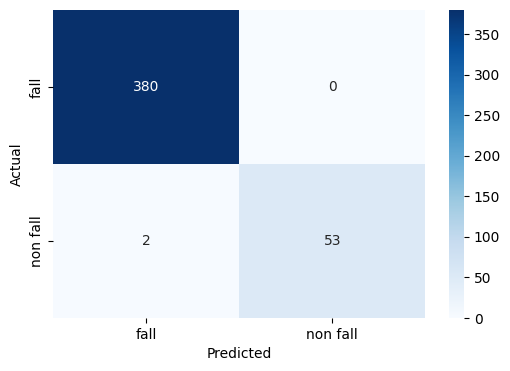

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y1, y_prob)

class_names = ['fall', "non fall"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()